# Import Dependencies

In [1]:
import os
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt

from TenGAN.ggan.zoo import ModelZoo

In [2]:
def trim(word):

    w = word

    trim_characters = [' ']
    trim_characters = {t_c:True for t_c in trim_characters}

    if w[0] in trim_characters:
        return trim(w[1:])

    if w[-1] in trim_characters:
        return trim(w[:-1])

    return w

In [3]:
def load_generator(config_id = None):
    
    if config_id is None: 
        print("Need a config_id!")
        return None
    
    hps = dict()

    with open(f'{os.getcwd()}/configs.txt', 'r') as f:
        text = f.read()
        config_txt = text[text.find(f'config_id: {config_id}'):text.find(f'config_id: {config_id+1}')]
        del text
        
    use_decomposition = '_NoDecomp' not in config_txt[config_txt.find("Generator Model")+17:config_txt.find("Discriminator Model")-1]
        
    hps_text = config_txt.split('{')[-1].split('}')[0]
    hp_text_list = hps_text.split('\n')

    for hp_text in hp_text_list:

        if len(hp_text) < 2: continue
        hp_name = trim(hp_text.split(':')[0])
        hp_value = trim(hp_text.split(':')[1])

        if hp_name in ['gen_model', 'disc_model']: hp_value = str(hp_value)
        else:
            try: hp_value = eval(hp_value)
            except: hp_value = str(hp_value)

        hps[hp_name] = hp_value
        
    generator_path = config_txt[config_txt.find('saved_generators/'):].split('\n')[0]

    substr = 'Tensor Shape'
    idx = config_txt.find(substr)
    tensor_shape = eval(trim(config_txt[idx+len(substr)+1: config_txt.find('\n', idx)]))
    del substr, idx

    zoo = ModelZoo()
    gen_class = zoo.get_model(hps['gen_model'])
    generator = gen_class(latent_dim = hps['latent_dim'],    # 1D noise vector input dim
                        layer_size = hps['gen_layer_size'],      # hidden_layer size
                        num_nodes = hps['num_nodes'],      # image height & width
                        rank = hps['decomp_rank'],            # tensor decomposition rank
                        num_views = hps['num_views'],       # num_channels for image
                        decomp_type = hps['tensor_model'],  # decomposition type - 'CPD', 'tucker' only so far
                        num_tensor_modes = len(list(tensor_shape))-1,   # number of tensor_modes, exclude mode for batch size
                        tensor_decomposition = use_decomposition,
                        opt = hps
                        )

    generator_state_dict = torch.load(generator_path)
    generator.load_state_dict(generator_state_dict)

    del zoo, gen_class, generator_path, generator_state_dict
    
    return generator

# Generate Images

# Paper Display

In [4]:
real_images = torch.load("/home/spaka002/Tensor_GAN/TenGAN/my_data/sample_EleEscan_1_1-5.pt")

In [10]:
config_id_list = [int(x) for x in input('config_id_list').split()]
num_configs = len(config_id_list)

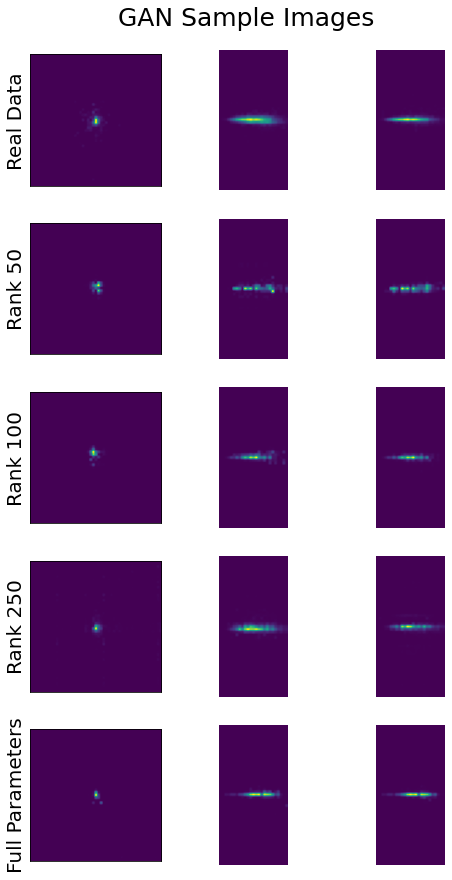

In [30]:
sample_i = 16

fig, axes = plt.subplots(num_configs+1, 3, figsize = (8, (num_configs+1)*3))

axes[0, 0].imshow(real_images[sample_i, :, :, 21])
axes[0, 0].set_ylabel('Real Data', fontsize = 20)
axes[0, 0].set_xticks([])
axes[0, 0].set_yticks([])

axes[0, 1].imshow(real_images[sample_i, :, 25, :])
axes[0, 1].axis('off')

axes[0, 2].imshow(real_images[sample_i, 25, :, :])
axes[0, 2].axis('off')


for ci in range(num_configs):
    
    generator = load_generator(config_id = config_id_list[ci])
    generator.change_device('cpu')
    generated_data = generator.generate(25).detach().permute(0, 2, 3, 1).numpy()
    generated_data.shape
    
    axes[ci+1, 0].imshow(generated_data[sample_i, :, :, 21])
    ylabel = f'Rank {generator.rank}' if ci != num_configs-1 else 'Full Parameters'
    axes[ci+1, 0].set_ylabel(ylabel, fontsize = 20)
    axes[ci+1, 0].set_xticks([])
    axes[ci+1, 0].set_yticks([])

    axes[ci+1, 1].imshow(generated_data[sample_i, :, 25, :])
    axes[ci+1, 1].axis('off')

    axes[ci+1, 2].imshow(generated_data[sample_i, 25, :, :])
    axes[ci+1, 2].axis('off')

fig.suptitle('GAN Sample Images', fontsize = 25, y = 0.92)
plt.show()

# Delete generators saved during training

In [7]:
if False:
    if int(input('Delete generators saved during training?')):
        import shutil
        shutil.rmtree(temp_save_folder)
        os.makedirs(temp_save_folder)
        
        print("Deleted generators saved during training.")